## Preparation

In [4]:
TF_ENABLE_ONEDNN_OPTS=0

In [5]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

%matplotlib inline

import os
import zipfile,fnmatch


## Run next block only first time - to download and unzip image datasets

In [ ]:
#download train and validation image datasets
!wget https://storage.googleapis.com/learning-datasets/horse-or-human.zip
!wget https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip

#unzip to respective folders
rootPath = os.getcwd()
pattern = '*.zip'
for root, dirs, files in os.walk(rootPath):
    for filename in fnmatch.filter(files, pattern):
        print(os.path.join(root, filename))
        zipfile.ZipFile(os.path.join(root, filename)).extractall(os.path.join(root, os.path.splitext(filename)[0]))

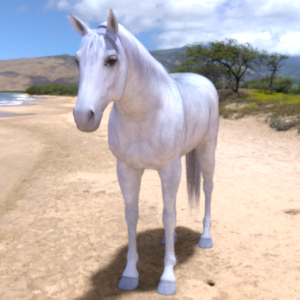

In [6]:
path = './horse-or-human/horses/'
name = 'horse01-0.png'
fullname = f'{path}/{name}'
load_img(fullname)

In [7]:
img = load_img(fullname, target_size=(150, 150))
x = np.array(img)
X = np.array([x])
X.shape
from tensorflow.keras.applications.xception import preprocess_input
X = preprocess_input(X)

## Develop the model with following structure

In [8]:
def make_model(learning_rate=0.002):
    input_shape=(150,150,3) # (height, width, channels)

    #Run this 2 times! The first time is some error!
    inputs = keras.Input(shape=input_shape)

    # Create a Convolutional layer to produce a tensor of outputs
    conv_2d_out = tf.keras.layers.Conv2D(32, #filters
                               (3, 3), #kernel_size
                               activation='relu', 
                               input_shape=input_shape)(inputs)
    #print(conv_2d_out.shape) # batch_size + (new_rows, new_cols, filters)

    # Create a Pooling layer to reduce the dimensionality of the feature map with max pooling 
    max_pool_2d_out = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),input_shape=input_shape)(conv_2d_out)
    #print(max_pool_2d_out.shape)

    # Create Flatten layer to convert all the resultant 2D arrays from pooled feature maps into a single linear vector
    vectors = tf.keras.layers.Flatten()(max_pool_2d_out)
    #print(vectors.shape)

    # Create Dense layer of 64
    outputs_dense_1 = tf.keras.layers.Dense(64, activation='relu')(vectors)
    #print(outputs_dense_1.shape)

    # Create Dense layer of 1 with sigmoid activation function
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(outputs_dense_1)
    #print(outputs.shape)

    model = keras.Model(inputs, outputs)

    ###################################################################

    # Define learning rate
    #learning_rate = learning_rate

    # Create optimizer
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.8)

    # Define loss function
    loss = tf.keras.losses.BinaryCrossentropy()

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy']) # evaluation metric accuracy
    
    return model

## Generators and Training

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

target_size = (150, 150) #homework requirement
batch_size = 20          #homework requirement
class_mode='binary'

# Build image generator for training 
train_gen = ImageDataGenerator(rescale=1./255)

# Load in train dataset into train generator
train_ds = train_gen.flow_from_directory(
    './horse-or-human/',
    target_size=target_size,
    batch_size=batch_size, 
    shuffle=True   
    ,class_mode=class_mode
)

Found 1027 images belonging to 2 classes.


In [10]:
train_ds.class_indices

{'horses': 0, 'humans': 1}

In [11]:
val_gen = ImageDataGenerator(rescale=1./255)

# Always keep validation as is - not to confuse the model
val_ds = val_gen.flow_from_directory(
    './validation-horse-or-human/',
    target_size=target_size,
    batch_size=batch_size, 
    shuffle=True   
    ,class_mode=class_mode
)

Found 256 images belonging to 2 classes.


In [13]:

chechpoint = keras.callbacks.ModelCheckpoint(
    'model_lr_0_02_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [14]:
# Train the model, validate it with validation data, and save the training history
scores = {}

for lr in [0.02]:#[0.002, 0.02, 0.2]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=[chechpoint])
    scores[lr] = history.history

    print()
    print()

0.02


2023-12-17 12:29:16.735183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-17 12:29:16.742548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-17 12:29:16.743255: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-17 12:29:16.744111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

Epoch 1/10


2023-12-17 12:29:18.936047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-17 12:29:19.550774: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-17 12:29:19.551359: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-17 12:29:19.551397: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-12-17 12:29:19.551860: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-17 12:29:19.551936: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


52/52 [==============================] - 8s 108ms/step - loss: 0.6213 - accuracy: 0.7020 - val_loss: 0.5657 - val_accuracy: 0.6328
Epoch 2/10
52/52 [==============================] - 5s 104ms/step - loss: 0.4304 - accuracy: 0.7984 - val_loss: 0.4446 - val_accuracy: 0.7422
Epoch 3/10
52/52 [==============================] - 5s 104ms/step - loss: 0.3078 - accuracy: 0.8793 - val_loss: 0.6000 - val_accuracy: 0.7891
Epoch 4/10
52/52 [==============================] - 5s 103ms/step - loss: 0.0581 - accuracy: 0.9796 - val_loss: 1.0954 - val_accuracy: 0.7031
Epoch 5/10
52/52 [==============================] - 5s 101ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 2.3965 - val_accuracy: 0.6133
Epoch 6/10
52/52 [==============================] - 5s 102ms/step - loss: 0.0112 - accuracy: 0.9990 - val_loss: 1.5800 - val_accuracy: 0.7148
Epoch 7/10
52/52 [==============================] - 5s 101ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.8099 - val_accuracy: 0.6875
Epoch 8/10
52/52 

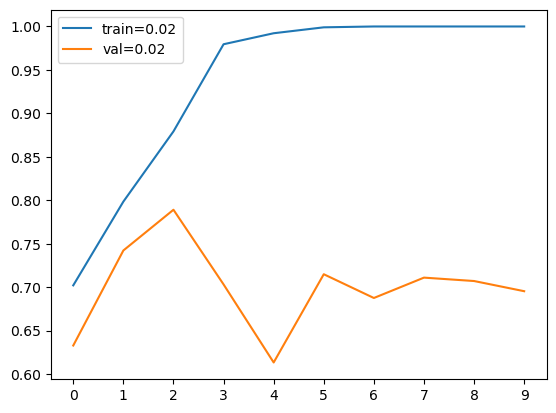

In [15]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()

## Load the model

In [16]:
model.save('model_lr_0_02_05_0.895.h5', save_format='h5')

## Restart the Kernel here

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

from tensorflow.keras.applications.xception import preprocess_input

2023-12-17 12:30:43.997704: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
model = keras.models.load_model('model_lr_0_02_05_0.895.h5')

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 175232)            0         
                                                                 
 dense (Dense)               (None, 64)                11214912  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                             

## This is the space to tune the model with different parameters